In [1]:
%%bash 
pip install opencv-python
pip install pydensecrf

You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from dlv3.utils import SegModel
from src.segment_tools import DataLoader, Data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.optimizers import Adam
from dlv3.utils import do_crf, plot_confusion_matrix
from dlv3.utils import Jaccard 
from dlv3.utils import sparse_crossentropy_ignoring_last_label
from dlv3.utils import sparse_accuracy_ignoring_last_label
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
'''
from glob import glob
#look at the VOC2012 dataset to understand the format of the data

f = sorted(glob('/datadrive/datasets/VOCdevkit/VOC2012/SegmentationClass/*'))
imf = sorted(glob('/datadrive/datasets/VOCdevkit/VOC2012/JPEGImages/*'))
exgt = Image.open(f[2])
exim = Image.open(imf[2])
f, ax = plt.subplots(1,2)
ax[0].imshow(Image.fromarray(np.array(exgt)))
ax[1].imshow(Image.fromarray(np.array(exim)))
##################################

##################################
#preprocess the image data
# this is preprocessing the data to format it like VOC2012 and then utilize the pre-existing 
# data generator
wd = '/datadrive/datasets'
d = Data('freiburg',wd )
freiburg_mapping = [0,170,255,102,60,120]
labels=['None','Road','Grass','Vegetation','Tree','Sky']
sz = (500,900)
d.resize_data(nrows=sz[1],ncols=sz[0])
d.remap_data(freiburg_mapping)
n = len(np.unique(np.array(d.gt)))
#d.im = np.array([np.array(i) for i in d.im])/255.
#d.gt = np.array([np.array(i) for i in d.gt])
#sz = d.im.shape[1:-1]

#need to move the data to another directory
output_dir = '/datadrive/datasets/freiburg_forest_annotated/processed'
im_out = '%s/images'%(output_dir)
gt_out = '%s/groundtruth'%(output_dir)
for i in range(len(d.im)):
    Image.fromarray(d.gt[i].astype('uint8')).save('%s/%s.png'%(gt_out,i))
    d.im[i].save('%s/%s.png'%(im_out,i))
'''

"\nfrom glob import glob\n#look at the VOC2012 dataset to understand the format of the data\n\nf = sorted(glob('/datadrive/datasets/VOCdevkit/VOC2012/SegmentationClass/*'))\nimf = sorted(glob('/datadrive/datasets/VOCdevkit/VOC2012/JPEGImages/*'))\nexgt = Image.open(f[2])\nexim = Image.open(imf[2])\nf, ax = plt.subplots(1,2)\nax[0].imshow(Image.fromarray(np.array(exgt)))\nax[1].imshow(Image.fromarray(np.array(exim)))\n##################################\n\n##################################\n#preprocess the image data\n# this is preprocessing the data to format it like VOC2012 and then utilize the pre-existing \n# data generator\nwd = '/datadrive/datasets'\nd = Data('freiburg',wd )\nfreiburg_mapping = [0,170,255,102,60,120]\nlabels=['None','Road','Grass','Vegetation','Tree','Sky']\nsz = (500,900)\nd.resize_data(nrows=sz[1],ncols=sz[0])\nd.remap_data(freiburg_mapping)\nn = len(np.unique(np.array(d.gt)))\n#d.im = np.array([np.array(i) for i in d.im])/255.\n#d.gt = np.array([np.array(i) for

In [5]:
backbone = 'mobilenetv2' #mobilenetv2, xception
#NET = 'deeplab_' + backbone
NET = 'original'
#NET = 'subpixel'

datadir = '/datadrive/datasets/freiburg_forest_annotated/processed'
impath = 'images'
gtpath = 'groundtruth'
n_classes = 6
bs = 5
og_sz = (650,1280)#(500,900)
r = 0.5
epochs = 40
sz = (int(og_sz[0]*r),int(og_sz[1]*r))
print('Image will be resized to:',sz)
Deeplab = SegModel(dataset=datadir,impath=impath,gtpath=gtpath,image_size=sz)
train_generator = Deeplab.create_generators(blur=5,crop_shape=None,mode='train',\
                                             n_classes=n_classes,horizontal_flip=True,\
                                             vertical_flip=False,brightness=0.3,\
                                             rotation=False,zoom=0.1,validation_split=.15,\
                                             seed=7,do_ahisteq=False)
valid_generator = Deeplab.create_generators(blur=0,crop_shape=None, mode='validation',\
                                                  n_classes=n_classes,horizontal_flip=True,\
                                                  vertical_flip=False,brightness=.1,\
                                                  rotation=False,zoom=.05,validation_split=.15,\
                                                  seed = 7,do_ahisteq = False)
model = Deeplab.create_seg_model(NET,n=n_classes)
losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

Image will be resized to: (325, 640)


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 325, 640, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 325, 640, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 163, 320, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 163, 320, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
lambda_2 (

In [40]:
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), \
              sample_weight_mode = "temporal",\
              loss = losses, metrics = metrics)

In [41]:
monitor = 'Jaccard'
mode = 'max'

# fine-tune model (train only last conv layers)
'''
flag = 0
for k, l in enumerate(model.layers):
    l.trainable = False
    if l.name == 'concat_projection':
        flag = 1
    if flag:
        l.trainable = True
'''
def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir='./logs/'+Deeplab.net, histogram_freq=0,\
                              write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = Deeplab.modelpath, verbose=1, \
                                   save_best_only=True, save_weights_only=True,\
                                   monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, \
                               verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,\
                                  patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)

Deeplab.set_num_epochs(epochs)
history = Deeplab.train_generator(model, train_generator, \
                                   valid_generator, callbacks=callbacks, mp = True)

Epoch 1/40
12/12 [==============================] - 39s 3s/step - loss: 1.4636 - Jaccard: 0.1867 - sparse_accuracy_ignoring_last_label: 0.3991 - val_loss: 3.5617 - val_Jaccard: 0.1853 - val_sparse_accuracy_ignoring_last_label: 0.4736

Epoch 00001: val_Jaccard improved from -inf to 0.18534, saving model to dlv3/weights/mobilenetv2_original.h5
Epoch 2/40
12/12 [==============================] - 21s 2s/step - loss: 0.8655 - Jaccard: 0.3425 - sparse_accuracy_ignoring_last_label: 0.6619 - val_loss: 2.4918 - val_Jaccard: 0.2489 - val_sparse_accuracy_ignoring_last_label: 0.5257

Epoch 00002: val_Jaccard improved from 0.18534 to 0.24889, saving model to dlv3/weights/mobilenetv2_original.h5
Epoch 3/40
12/12 [==============================] - 21s 2s/step - loss: 0.7159 - Jaccard: 0.4053 - sparse_accuracy_ignoring_last_label: 0.7240 - val_loss: 2.5342 - val_Jaccard: 0.2231 - val_sparse_accuracy_ignoring_last_label: 0.3468

Epoch 00003: val_Jaccard did not improve
Epoch 4/40
12/12 [===============


Epoch 00028: val_Jaccard did not improve
Epoch 29/40
12/12 [==============================] - 22s 2s/step - loss: 0.2461 - Jaccard: 0.6767 - sparse_accuracy_ignoring_last_label: 0.8974 - val_loss: 0.7004 - val_Jaccard: 0.5226 - val_sparse_accuracy_ignoring_last_label: 0.7204

Epoch 00029: val_Jaccard did not improve
Epoch 30/40
12/12 [==============================] - 22s 2s/step - loss: 0.2542 - Jaccard: 0.6777 - sparse_accuracy_ignoring_last_label: 0.8961 - val_loss: 0.6209 - val_Jaccard: 0.5498 - val_sparse_accuracy_ignoring_last_label: 0.7416

Epoch 00030: val_Jaccard improved from 0.53513 to 0.54981, saving model to dlv3/weights/mobilenetv2_original.h5
Epoch 31/40
12/12 [==============================] - 22s 2s/step - loss: 0.2507 - Jaccard: 0.6827 - sparse_accuracy_ignoring_last_label: 0.8955 - val_loss: 0.6355 - val_Jaccard: 0.5440 - val_sparse_accuracy_ignoring_last_label: 0.7469

Epoch 00031: val_Jaccard did not improve
Epoch 32/40
12/12 [==============================] - 22s

In [6]:
model1 = Deeplab.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model1.load_weights('dlv3/weights/mobilenetv2_original.h5')
#model2 = Deeplab.create_seg_model(net='subpixel',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
#model2.load_weights('dlv3/weights/mobilenetv2_subpixel.h5')

In [7]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

def calculate_iou(SegClass, model, image_size, nb_classes = 21):
    SegClass.set_batch_size(1)
    valid_generator = SegClass.create_generators(crop_shape = None,mode = 'validation', n_classes = nb_classes, 
                                                 horizontal_flip = False, vertical_flip = False,
                                                 brightness=0, rotation=False,
                                                 zoom=0, validation_split = .05, seed = 7, do_ahisteq = False)
    label = np.zeros((len(valid_generator),np.prod(image_size)), dtype='float32')
    X = np.zeros((len(valid_generator), image_size[0], image_size[1], 3), dtype='float32')
    for n in range(len(valid_generator)):
        x,y,_ = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        X[n,:,:,:] = x
    preds = model.predict(X, batch_size=1)
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    total = 0
    mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)
    flat_pred = np.ravel(mask).astype('int')
    flat_label = np.ravel(label).astype('int')
    for p, l in zip(flat_pred, flat_label):
        if l == nb_classes:
            continue
        if l < nb_classes and p < nb_classes:
            conf_m[l-1, p-1] += 1
        else:
            print('Invalid entry encountered, skipping! Label: ', l,
                    ' Prediction: ', p, ' Img_num: ', img_num)
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    meanIOU = np.mean(IOU)
    return conf_m

Text(0.5,1,'Original DeepLab + CRF\nmIOU: 0.71')

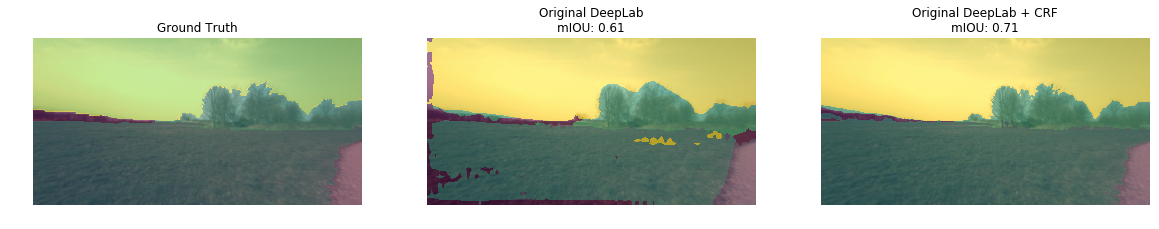

In [8]:
i = np.random.randint(0, len(valid_generator))
x,y,s = valid_generator.__getitem__(i)
preds1 = np.argmax(model1.predict(x), -1)[0].reshape(sz)

im = x[0].astype('uint8')
gt = y[0].reshape(sz).astype('int32')
MAP = do_crf(im, preds1, zero_unsure=False)

f, ax = plt.subplots(1,3,figsize=(20,14))
ax[0].imshow(x[0].astype('uint8'))
ax[0].imshow(gt, alpha=.5)
ax[0].set_axis_off()
ax[1].imshow(x[0].astype('uint8'))
ax[1].imshow(preds1, alpha=.5)
ax[1].set_axis_off()
ax[2].imshow(x[0].astype('uint8'))
ax[2].imshow(MAP, alpha=.5)
ax[2].set_axis_off()

ax[0].set_title('Ground Truth')
ax[1].set_title('Original DeepLab\nmIOU: '+str(mIOU(gt, preds1)))
ax[2].set_title('Original DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))

In [10]:
conf_1 = calculate_iou(Deeplab, model1, image_size=sz, nb_classes = 6)

Text(0.5,1,'Original DeepLab\nMean IOU: 0.84')

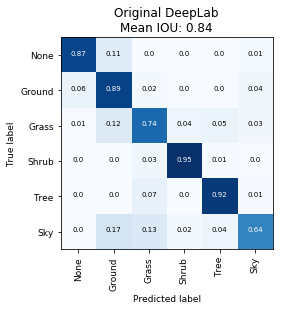

In [11]:
classes =['None','Ground','Grass','Shrub','Tree','Sky']
plt.figure(figsize=(4,4))
plt.subplot(111)
cm1=plot_confusion_matrix(conf_1, classes, normalize=True)
plt.title('Original DeepLab\nMean IOU: '+ str(np.round(np.diag(cm1).mean(), 2)))

In [14]:
#try some phenocam images?
def discrete_matshow(data, f):
    cmap = plt.get_cmap('viridis', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = f.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))
    return(cmap, cax)

In [21]:
im_files = sorted(glob('/datadrive/datasets/emammal/*.jpg'))
print(im_files)

['/datadrive/datasets/emammal/d39279s38i3.jpg', '/datadrive/datasets/emammal/d45725s47i1.jpg', '/datadrive/datasets/emammal/d45857s90i1.jpg', '/datadrive/datasets/emammal/d50984s45i2.jpg', '/datadrive/datasets/emammal/d51726s20i4.jpg', '/datadrive/datasets/emammal/d51728s23i6.jpg', '/datadrive/datasets/emammal/d53354s6i1.jpg', '/datadrive/datasets/emammal/d53355s13i1.jpg', '/datadrive/datasets/emammal/d54248s7i16.jpg', '/datadrive/datasets/emammal/d54631s2i16.jpg', '/datadrive/datasets/emammal/d54645s27i8.jpg', '/datadrive/datasets/emammal/d54661s25i11.jpg', '/datadrive/datasets/emammal/d54683s48i2.jpg']


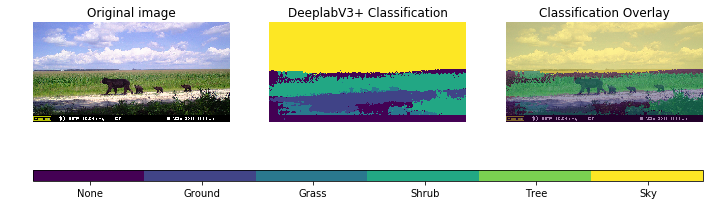

In [38]:
from glob import glob
import os
#sitename = 'grandteton'
#sitename = 'bozeman'
#sitename = 'grca1pj'
#sitename = 'arsmorris1'
#im_files = sorted(glob('/content/images/%s*'%(sitename)))
im_files = sorted(glob('/datadrive/datasets/emammal/*.jpg'))
#i = np.random.randint(0,len(im_files))
i=3
#i=11
#print(i)
im = Image.open(im_files[i]).resize((sz[1],sz[0]))
image = np.expand_dims(np.array(im),0)
yhat = np.argmax(model1.predict([image]), -1)[0].reshape(sz)
MAP = do_crf(image[0], yhat, zero_unsure=False)
f, ax = plt.subplots(1,3,figsize=(12,3))

cmap = plt.get_cmap('viridis', len(classes))
ax[0].imshow(image[0].astype('uint8'))
ax[0].set_axis_off()
ax[0].set_title('Original image')
ax[0].set_aspect('equal')
cim = ax[1].imshow(MAP, cmap=cmap)
ax[1].set_axis_off()
ax[1].set_title('DeeplabV3+ Classification')
ax[1].set_aspect('equal')

ax[2].imshow(image[0].astype('uint8'))
ax[2].imshow(MAP, alpha=.5)
ax[2].set_axis_off()
ax[2].set_title('Classification Overlay')
ax[2].set_aspect('equal')
    
p0 = ax[0].get_position().get_points().flatten()
p1 = ax[2].get_position().get_points().flatten()
cbar_ax = f.add_axes([p0[0], 0, p1[2]-p0[0],0.05])
ticks = np.arange(6) + 0.01
#mat = plt.matshow(MAP,cmap=cmap,vmin = np.min(MAP)-.5, vmax = np.max(MAP)+.5)
cbar = f.colorbar(mat, cax=cbar_ax, ticks=ticks, orientation='horizontal')
cbar.ax.set_xticklabels(classes)
fileout = os.path.basename(im_files[i])
f.savefig('/content/figs/deep_%s'%fileout, dpi=100, bbox_inches='tight')

In [348]:
mask = MAP
rm_mask = (mask==5) | (mask==0)
shrub_mask = (mask==3)
grass_mask = (mask==2)

In [306]:
# we can to use the mask to show what would the aggregate NDVI be for the image be, and what 
# would it be with segmentation
sorted(im_files)
im_array = np.array([np.array(Image.open(i).resize((sz[1],sz[0]))) for i in sorted(im_files)])

In [287]:
import datetime
dates = []
for f in sorted(im_files):
    y, m, d = f.split('_')[1:4]
    dates.append(datetime.datetime(int(y),int(m),int(d)))
dates = np.array(dates)    

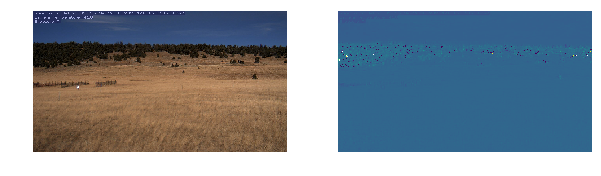

In [307]:
def grvi(im):
    g = im[:,:,1]/255.
    r = im[:,:,0]/255.
    return((g-r)/(g+r))
def gcc(im):
    g = im[:,:,1]/255.
    b = im[:,:,2]/255.
    r = im[:,:,0]/255.
    return(g/(g+r+b))

gcc_array = np.array([gcc(i) for i in im_array])
f, ax = plt.subplots(1,2, figsize=(10,4))
i=2
ax[0].imshow(im_array[i])
ax[0].set_axis_off()
ax[1].imshow(gcc_array[i])
ax[1].set_axis_off()
#plt.colorbar()

In [308]:
gcc_array[np.isnan(gcc_array)] = 0

In [352]:
gcc_ts = np.mean(gcc_array, axis=(1,2))
gcc_ts_shrub=np.array([np.mean(g[shrub_mask]) for g in gcc_array])
gcc_ts_grass=np.array([np.mean(g[grass_mask]) for g in gcc_array])
gcc_ts_veg=np.array([np.mean(g[~rm_mask]) for g in gcc_array])

Text(0,0.5,'Green Chromatic Coordinate')

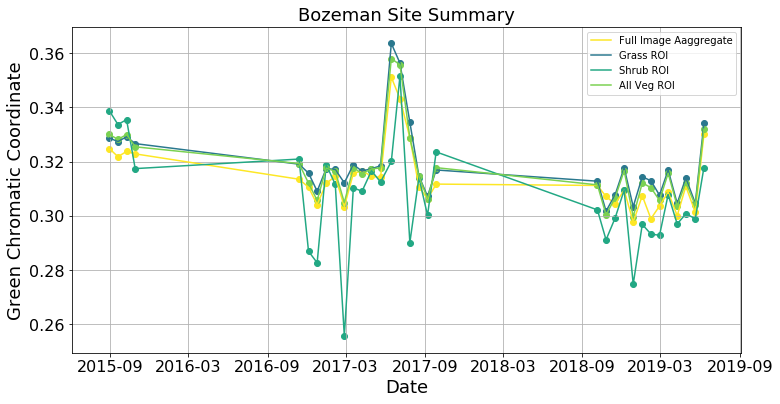

In [364]:
f,ax=plt.subplots(1,1,figsize=(12,6))
ax.scatter(dates,gcc_ts, color=cmap.colors[-1])
ax.plot(dates,gcc_ts, color=cmap.colors[-1], label='Full Image Aaggregate')
ax.scatter(dates,gcc_ts_grass, color=cmap.colors[2])
ax.plot(dates,gcc_ts_grass, color=cmap.colors[2], label='Grass ROI')
ax.scatter(dates,gcc_ts_shrub, color=cmap.colors[3])
ax.plot(dates,gcc_ts_shrub, color=cmap.colors[3], label='Shrub ROI')
ax.scatter(dates,gcc_ts_veg, color=cmap.colors[-2])
ax.plot(dates,gcc_ts_veg, color=cmap.colors[-2], label='All Veg ROI')
ax.grid(True)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Bozeman Site Summary', fontsize=18)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Green Chromatic Coordinate', fontsize=18)